# 7w-asgn
* Q1:学习理解如何用最小二乘法的矩阵公式来得到线性回归的解，并使用numpy库来实现该算法。
* Q2:使用pandas库中的函数下载上证综指和任一成份股票数据，计算日收益率，对这两组数据建立回归模型，将上证综指的收益率作为解释变量，说明这个模型的用处。
* Q3:在kaggle网站上找到titanic数据，并使用logistic回归来建模，研究分析每个因素对于生存的重要性。
* Q4:搜集某个城市过去1个月的PM2.5小时级数据，根据时间序列预测方法，来预测未来三天的PM2.5情况

## Q1: OLS in Linear Regression

* [OLS wiki](https://en.wikipedia.org/wiki/Ordinary_least_squares)
* [Linear Regression wiki](https://en.wikipedia.org/wiki/Linear_regression_model)

* 假设 sample size = n
    * $\{y_i,x_i\}_{i=1}^n$
    * $y$为 dependent variable, scalar
    * $x$为 a vector of p explanatory variables, ($x_1,x_2,...x_p$), 也成为 design matrix
* Linear Regression Model: 
    * $y_i=x_i^T\beta+\epsilon_i$, $\beta$ 是`pX1`的 vector
    * 写成 matrix form: $y=X\beta+\epsilon$
        * $X$ 是 `nXp` 的 matrix of explanatory variable, $x_1,x_2,...x_p$
        * $\beta$ 就是想要求的系数
        * $y, \epsilon$ 都是 `pX1` vector
* 残差: $residual=y_i-x_i^T b$ 假设 b 为某一个$\beta$的取值
    * residual 是真实值与预测值之间的差距, 所以可以评估 model 拟合程度
* 残差平方和 sum of squared residuals (SSR), 评估整体 model 拟合情况: 
$$S(b)=\sum_{i=1}^n (y_i-x_i^T b)^2$$
* 在线性回归中使用 OLS 去拟合, 也就是想要使 SSR=S(b) 最小化.
    * 所以 $ \hat{\beta} = argmin S(b)$
* 求 $S(b)$ 何时最小, 对 b 求导, 令导数等于0:
    * $\frac{dS}{db}=\sum_{i=1}^n 2(y_i-x_i^T b)(-x_i^T) = 0$
    * $\hat{\beta} = \lgroup\frac{1}{n}\sum_{i=1}^n x_i x_i^T\rgroup ^ {-1} \frac{1}{n}\sum_{i=1}^n x_i y_i$
    * 写成 matrix form: $\hat{\beta} = (X^T X)^{-1}X^T y$

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf #公式界面
import statsmodels.graphics.api as smg # 图形界面
import patsy #转化公式
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

In [2]:
from numpy.linalg import inv

def ols(X_matrix, y):
    '''
    returns coeff array by using OLS closed-form matrix formula
    X_matrix: design matrix
    y: column raw data
    '''
    w = inv(np.dot(X_matrix.T,X_matrix)).dot(X_matrix.T).dot(y)
    return w

In [3]:
# 用一个例子来试一下

np.random.seed(42424242)
N = 100
x1 = np.random.randn(N)
x2 = np.random.randn(N)
x3 = np.random.randn(N)

data = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3})

def y_true(x1,x2,x3):
    return 2 + x1 + 3*x2 + 4.5*x3

data["y_true"] = y_true(x1,x2,x3)
e = np.random.randn(N) #noise, ~Normal
data["y"] = data["y_true"] + e

data.head()

,x1,x2,x3,y_true,y
0,-0.142043,-0.207324,0.376192,2.928850,1.282375
1,-0.640962,-0.360073,-0.179685,-0.529764,2.294898
2,0.269488,0.316936,-0.076239,2.877220,1.561066
3,-0.765718,1.105926,1.070577,9.369655,8.616175
4,-0.103410,0.965879,0.013798,4.856319,4.562518


In [4]:
X_matrix = np.hstack((np.ones((N,1)),data.iloc[:,0:3]))

In [5]:
w = ols(X_matrix, data["y"])

In [6]:
w

array([ 1.9885126 ,  0.91041719,  2.83220741,  4.53867518])

In [7]:
# 如果使用 statsmodel
model = smf.ols("y ~ x1 + x2 + x3", data)
result = model.fit()

In [8]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     881.3
Date:                Sat, 12 Mar 2016   Prob (F-statistic):           1.06e-69
Time:                        22:05:55   Log-Likelihood:                -138.42
No. Observations:                 100   AIC:                             284.8
Df Residuals:                      96   BIC:                             295.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.9885      0.102     19.558      0.0

比较 coeff 计算出来是一致的, p 值都很小, 所有 coeff 都是显著的, $R^2$为0.965, 拟合很好.

## Q2: Linear Regression 上证综指&成分股 日收益率

In [9]:
import pandas_datareader
from pandas_datareader import data

import datetime
start = datetime.datetime(2015,3,1)
end = datetime.datetime(2016,3,1)

In [10]:
sse=data.DataReader("000001.SS","yahoo",start,end) # 上证指数

In [11]:
pingan=data.DataReader("601318.SS","yahoo",start,end)#中国平安

In [12]:
def cal_r_daily(df): # calculate daily return
    df=df.drop(["Open","High","Low","Close","Volume"],axis=1)
    df=df/df.shift(1) - 1
    df.columns=["Daily_return"]
    df=df.dropna()
    return df

In [13]:
sse_d=cal_r_daily(sse)
sse_d.head()

,Daily_return
Date,
2015-03-03,-0.021950
2015-03-04,0.005050
2015-03-05,-0.009468
2015-03-06,-0.002244
2015-03-09,0.018888


In [14]:
pingan_d=cal_r_daily(pingan)
pingan_d.head()

,Daily_return
Date,
2015-03-03,-0.039787
2015-03-04,-0.002671
2015-03-05,-0.026602
2015-03-06,-0.002752
2015-03-09,0.020631


以上证指数为解释变量做线性回归, 假设:
$$ pingan = \beta_0 + \beta_1*sse + \epsilon$$

In [15]:
d_data=pd.concat([sse_d,pingan_d],axis=1).dropna()

In [16]:
d_data.columns=["SSE","PingAn"]
d_data.describe()

,SSE,PingAn
count,232.000000,232.000000
mean,-0.000500,0.001223
std,0.026663,0.070343
min,-0.084907,-0.508081
25%,-0.012317,-0.014752
50%,0.001853,-0.000753
75%,0.017851,0.014346
max,0.076940,0.838211


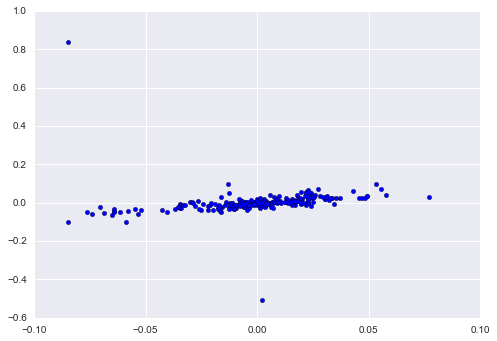

In [17]:
plt.scatter(d_data['SSE'],d_data['PingAn']);

In [18]:
result_lr = smf.ols("PingAn ~ SSE", d_data).fit()
# linear regression by ols

In [19]:
print(result_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                 PingAn   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.685
Date:                Sat, 12 Mar 2016   Prob (F-statistic):             0.0561
Time:                        22:06:05   Log-Likelihood:                 288.97
No. Observations:                 232   AIC:                            -573.9
Df Residuals:                     230   BIC:                            -567.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0014      0.005      0.302      0.7

In [20]:
# Intercept 的 p 值很高, 说明不需要 Intercept
result_lr = smf.ols("PingAn ~ -1+SSE", d_data).fit()

In [22]:
print(result_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                 PingAn   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.679
Date:                Sat, 12 Mar 2016   Prob (F-statistic):             0.0563
Time:                        22:07:17   Log-Likelihood:                 288.92
No. Observations:                 232   AIC:                            -575.8
Df Residuals:                     231   BIC:                            -572.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
SSE            0.3303      0.172      1.918      0.0

* OLS 计算系数为0.3303, positive, 说明是正相关的
* $R^2$ 只有0.016, 很低, 说明线性回归拟合的不好, 这个 model 只能解释大概1.6%的数据

改进?:
* 从5w 作业看, 单只股票日收益率mean都约为0, 对上证指数和平安进行 Hypothesis test

In [23]:
stats.ttest_ind(d_data.SSE,d_data.PingAn)

Ttest_indResult(statistic=-0.34890306020771678, pvalue=0.72732104066011416)

p 值都不够小, 所以它们的 mean return 是相同的, 都约为0.

考虑换成 log return 来试试.

In [24]:
def cal_log(df): # calculate log
    df=df.drop(["Open","High","Low","Close","Volume"],axis=1)
    df=np.log(df)
    df.columns=["Log_price"]
    df=df.dropna()
    return df

In [25]:
log_sse=cal_log(sse)
log_sse.head()

,Log_price
Date,
2015-03-02,8.112612
2015-03-03,8.090418
2015-03-04,8.095455
2015-03-05,8.085942
2015-03-06,8.083696


In [26]:
log_pingan=cal_log(pingan)
log_pingan.head()

,Log_price
Date,
2015-03-02,3.535379
2015-03-03,3.494779
2015-03-04,3.492104
2015-03-05,3.465142
2015-03-06,3.462387


In [27]:
log_data=pd.concat([log_sse,log_pingan],axis=1).dropna()
log_data.columns=["SSE","PingAn"]

In [28]:
result_log = smf.ols("PingAn ~ SSE", log_data).fit()
print (result_log.summary())

                            OLS Regression Results                            
Dep. Variable:                 PingAn   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     351.7
Date:                Sat, 12 Mar 2016   Prob (F-statistic):           2.60e-48
Time:                        22:08:04   Log-Likelihood:                 220.74
No. Observations:                 233   AIC:                            -437.5
Df Residuals:                     231   BIC:                            -430.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.3827      0.317     -7.514      0.0

$R^2$有0.604比前面日收益率的线性回归提高不少, 说明这个 model 拟合比较好. Intercept 和 SSE 的 p 值都很小, 很显著. 所以 log price 之间的线性关系比较显著.

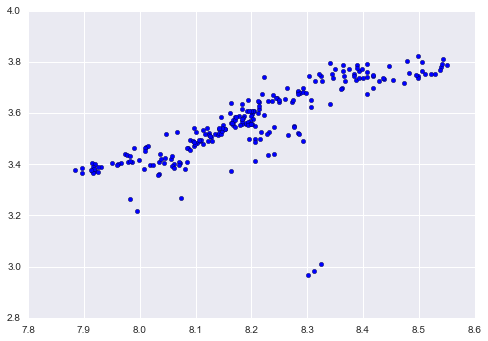

In [29]:
plt.scatter(log_data['SSE'],log_data['PingAn']);
# scatter plot 发现线性关系比前面一个日收益率的图更明显

In [31]:
#根据 scatter 有几个异常点 在 y 轴等于3.0左右
log_data.PingAn[log_data.PingAn<3.2]

Date
2015-07-22    2.967744
2015-07-23    3.008797
2015-07-24    2.984924
Name: PingAn, dtype: float64

In [32]:
np.exp(3)

20.085536923187668

中国平安的股价并没有到过20, 但在2015年7月27日曽有过一次拆股及派息, 发现 yahoo 数据表格其实是这样显示 dividend 和 split. 22-24号对于拆股后的价格调整是错误的, 22-24号调整后的价格应该为40块左右, 而 yahoo 的数据将之又折半至20块左右.

<table>
  <tr>
    <th>date</th>
    <th>Open</th>
    <th>High</th>
    <th>Low</th>
    <th>Close</th>
    <th>Volume</th>
    <th>Adj Close</th>
  </tr>
  <tr>
    <td>Jul 27, 2015</td>
    <td>39.89</td>
    <td>40.08</td>
    <td>36.39</td>
    <td>36.59</td>
    <td>171,259,600</td>
    <td>36.37</td>
  </tr>
  <tr>
    <td>Jul 27, 2015</td>
    <td colspan="6">0.50 Dividend</td>
  </tr>
  <tr>
    <td>Jul 27, 2015</td>
    <td colspan="6">20: 10 Stock Split</td>
  </tr>
  <tr>
    <td>Jul 24, 2015</td>
    <td>41.35</td>
    <td>41.35</td>
    <td>40.28</td>
    <td>40.31</td>
    <td>236,356,400</td>
    <td>19.79</td>
  </tr>
  <tr>
    <td>Jul 23, 2015</td>
    <td>39.98</td>
    <td>41.39</td>
    <td>39.74</td>
    <td>41.29</td>
    <td>309,046,100</td>
    <td>20.26</td>
  </tr>
  <tr>
    <td>Jul 22, 2015</td>
    <td>40.23</td>
    <td>40.28</td>
    <td>39.25</td>
    <td>39.63</td>
    <td>176,911,900</td>
    <td>19.45</td>
  </tr>
</table>

暂时线性关系可写为: $\log{PingAn} = -2.3831 + 0.7252* \log{SSE}$

平安和上证指数也是正相关的, 但 coeff 小于1, 也就是说明上证指数若上涨1%, 那中国平安的涨幅应该就是小于1%的, 影响偏小.

## Q3: titanic, what sorts of people were likely to survive

* [kaggle](https://www.kaggle.com/c/titanic)
* [titanic notebook](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic/notebook)
* [seaborn-categorical plotting](https://stanford.edu/~mwaskom/software/seaborn/tutorial/categorical.html)

In [34]:
train_data=pd.read_csv("train.csv", header=0)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [35]:
test_data=pd.read_csv("test.csv", header=0)

In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [37]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


`Name,ID,Ticket number` 与预测无关, 可以从 model 中排除

另外, 从 info 发现:
* `Age`中有一些缺失值, 需要处理
* `Embarked`在 trian data 中有2个缺失值
* `Cabin`有非常多缺失值, 对 survival 影响不大
* `Pclass, Sex, Embarked`都是categorical variable (discrete), 需要使用 dummy variable转化

**VARIABLE DESCRIPTIONS:**
```
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations
```

In [38]:
# drop id, name,ticket,cabin
train_data = train_data.drop(["PassengerId","Name","Ticket","Cabin"],axis=1)

In [39]:
test_data = test_data.drop(["Name","Ticket","Cabin"],axis=1)

In [40]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [41]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [42]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [43]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [44]:
train_data["SibSp"].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [45]:
train_data["Parch"].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [46]:
# 对于 Embarked 缺失的两个值, 就用 freq 最高的 "S" 填充
train_data["Embarked"] = train_data["Embarked"].fillna("S")

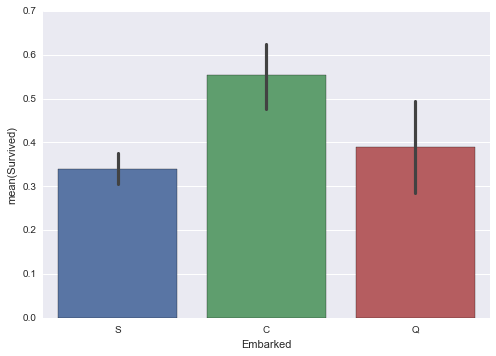

In [47]:
sns.barplot(x="Embarked", y="Survived", data=train_data);
# C 的生存率最高, 其次 Q, 最低为 S
# S 的人数最高, 占一大部分, Q 的人数最少

In [48]:
# 因为 S和 Q的平均生存率都低于0.5, 所以如果在 prediction 中可以去掉 S和 Q,保留 C dummy variable
# 但是逻辑上考虑, 在哪里上船应该和生存率没有关系, 可以考虑去掉

train_data = train_data.drop(["Embarked"],axis=1)

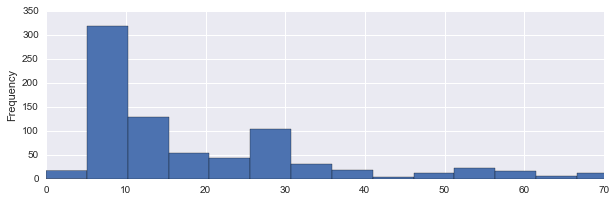

In [49]:
# Fare histogram
train_data['Fare'].plot(kind='hist', figsize=(10,3),bins=100, xlim=(0,70));

# 最多的部分在10一下, 大部分在30以下

In [50]:
# get fares for survived & not survived passengers 
fare_dead = train_data["Fare"][train_data["Survived"] == 0]
fare_survived = train_data["Fare"][train_data["Survived"] == 1]
print fare_dead.describe()
print "--------------------"
print fare_survived.describe()

# 明显存活的人 fare 更高, fare 和 Pclass 有关, class 越高, 所付船票越高

count    549.000000
mean      22.117887
std       31.388207
min        0.000000
25%        7.854200
50%       10.500000
75%       26.000000
max      263.000000
Name: Fare, dtype: float64
--------------------
count    342.000000
mean      48.395408
std       66.596998
min        0.000000
25%       12.475000
50%       26.000000
75%       57.000000
max      512.329200
Name: Fare, dtype: float64


In [51]:
# Age 有一些 missing values, 最简单的处理方法是删掉, sample size 会减小
# 或者 fillna 用一些方法填补
# 此处简单处理, dropna

train_data2 = train_data.dropna()
train_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 7 columns):
Survived    714 non-null int64
Pclass      714 non-null int64
Sex         714 non-null object
Age         714 non-null float64
SibSp       714 non-null int64
Parch       714 non-null int64
Fare        714 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 44.6+ KB


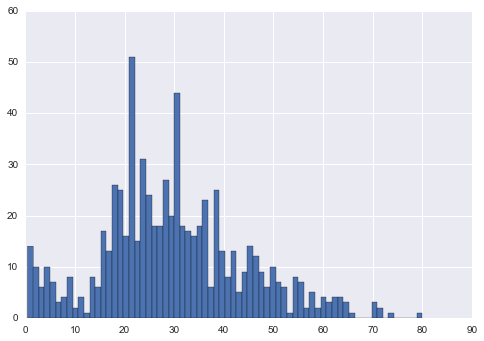

In [52]:
# Age histogram
train_data2['Age'].hist(bins=70);

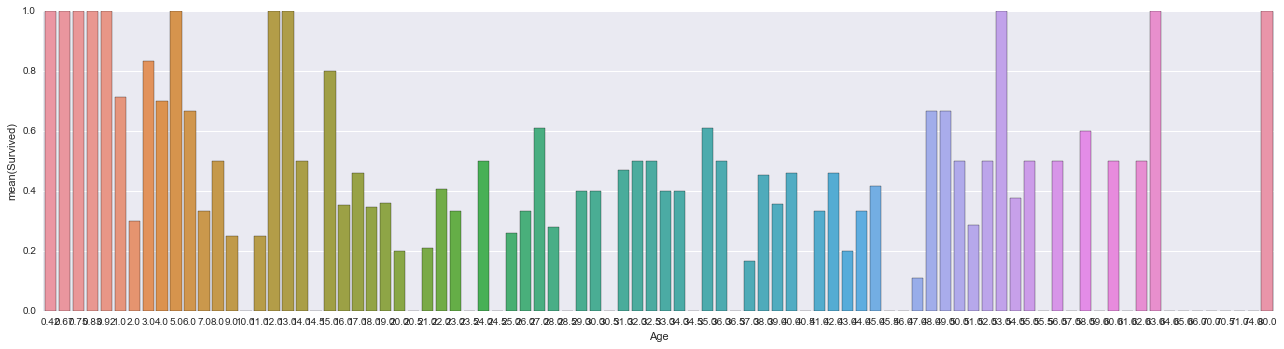

In [53]:
# average survived passengers by age
fig, ax = plt.subplots(1,1,figsize=(18,5))
average_age = train_data2[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)
fig.tight_layout()

# seems like 16岁以下的存活率比较高
# 16~47岁存活率都较低

In [54]:
# SibSp & Parch, 有关是否有兄弟姐妹或者父母孩子一起在船上
# 可以合并为是否有家人一起

train_data2['Family'] = train_data2["Parch"] + train_data2["SibSp"]
#A value is trying to be set on a copy of a slice from a DataFrame.
#Try using .loc[row_indexer,col_indexer] = value instead

train_data2['Family'].loc[train_data2["Parch"] + train_data2["SibSp"] > 0] = 1
train_data2['Family'].loc[train_data2["Parch"] + train_data2["SibSp"] == 0] = 0

# Family 变成一个 categorical variable

# drop Parch & SibSp
train_data2 = train_data2.drop(['SibSp','Parch'], axis=1)

/Users/mn/program/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mn/program/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/mn/program/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mn

In [55]:
train_data2["Family"].value_counts()

0    404
1    310
Name: Family, dtype: int64

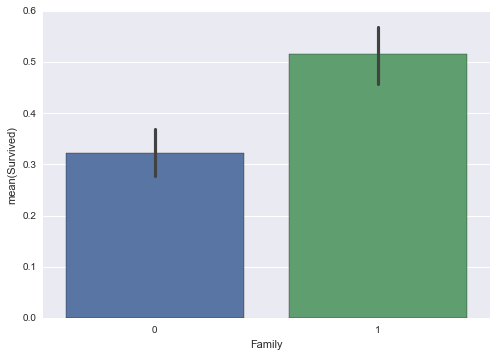

In [56]:
sns.barplot(x="Family", y="Survived", data=train_data2);
# 1 表示有和家人一起登船, 所以有家人一起的存活几率大过没有的

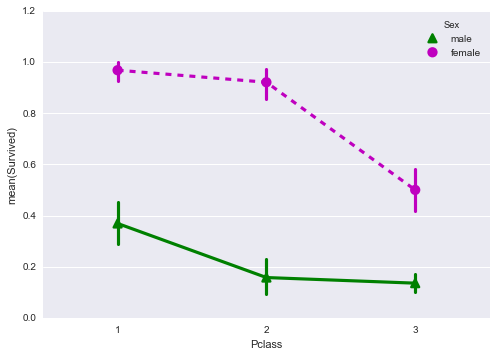

In [57]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=train_data,
              palette={"male": "g", "female": "m"},
              markers=["^", "o"], linestyles=["-", "--"]);

# Pclass 和 sex 综合来看, 女性生存率明显比男性高, 按 class 来看, class 越高生存率越高
# 所以1st class 女性的生存率几乎接近100%

In [58]:
# Pclass, Sex 是 categorical variable, 转化成 dummy variable
# Pclass dummy
pclass_dummy = pd.get_dummies(train_data2['Pclass'],prefix="class")
pclass_dummy.drop(['class_3'], axis=1, inplace=True)
# Sex
sex_dummy = pd.get_dummies(train_data2['Sex'])
sex_dummy.drop(['male'], axis=1, inplace=True)

In [59]:
# drop original
train_data2.drop(['Pclass','Sex'],axis=1,inplace=True)
# append dummies
train_data2 = train_data2.join([pclass_dummy, sex_dummy])

In [60]:
train_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 7 columns):
Survived    714 non-null int64
Age         714 non-null float64
Fare        714 non-null float64
Family      714 non-null int64
class_1     714 non-null float64
class_2     714 non-null float64
female      714 non-null float64
dtypes: float64(5), int64(2)
memory usage: 44.6 KB


In [61]:
model1 = smf.logit("Survived ~ Age+Fare+Family+class_1+class_2+female",data=train_data2)
result1 = model1.fit()

Optimization terminated successfully.
         Current function value: 0.452874
         Iterations 6


In [62]:
print(result1.summary())

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      707
Method:                           MLE   Df Model:                            6
Date:                Sat, 12 Mar 2016   Pseudo R-squ.:                  0.3295
Time:                        23:04:43   Log-Likelihood:                -323.35
converged:                       True   LL-Null:                       -482.26
                                        LLR p-value:                 1.244e-65
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.2614      0.273     -4.615      0.000        -1.797    -0.726
Age           -0.0379      0.008     -4.783      0.000        -0.054    -0.022
Fare           0.0009      0.002      0.389      0.6

In [63]:
# Fare, Family p 值高, 可以去掉
model2 = smf.logit("Survived ~ Age+class_1+class_2+female",data=train_data2)
result2 = model2.fit()
print result2.summary()

Optimization terminated successfully.
         Current function value: 0.453279
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      709
Method:                           MLE   Df Model:                            4
Date:                Sat, 12 Mar 2016   Pseudo R-squ.:                  0.3289
Time:                        23:05:03   Log-Likelihood:                -323.64
converged:                       True   LL-Null:                       -482.26
                                        LLR p-value:                 2.074e-67
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.3264      0.248     -5.351      0.000        -1.812    -0.841
Age           -0.0370      0.

In [64]:
# define training and testing sets

X_train = train_data2.drop("Survived",axis=1)
Y_train = train_data2["Survived"]

In [65]:
# sklearn 包中的 logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logitreg = LogisticRegression()
logitreg.fit(X_train, Y_train)

logitreg.score(X_train, Y_train)

0.79411764705882348

In [66]:
# deal with test data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 29.4+ KB


In [67]:
# fill fare missing value by median
test_data["Fare"].fillna(test_data["Fare"].median(), inplace=True)

In [68]:
# get average, std, and number of NaN values in test data
avg_age_test = test_data["Age"].mean()
std_age_test = test_data["Age"].std()
count_nan = test_data["Age"].isnull().sum()

# randomly sampled value uniformly in [mean-std,mean+std)
rand_age = np.random.randint(avg_age_test - std_age_test, avg_age_test + std_age_test, 
                           size = count_nan)
# fill missing value in Age by the random samples
test_data["Age"][np.isnan(test_data["Age"])] = rand_age

/Users/mn/program/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [69]:
test_data.drop("Embarked",axis=1,inplace=True)

In [70]:
# add Family to test
test_data['Family'] = test_data["Parch"] + test_data["SibSp"]

test_data['Family'].loc[test_data["Parch"] + test_data["SibSp"] > 0] = 1
test_data['Family'].loc[test_data["Parch"] + test_data["SibSp"] == 0] = 0

# drop Parch & SibSp
test_data = test_data.drop(['SibSp','Parch'], axis=1)

In [71]:
# Pclass dummy
pclass_dummy_test = pd.get_dummies(test_data['Pclass'],prefix='class')
pclass_dummy_test.drop(['class_3'], axis=1, inplace=True)
# Sex
sex_dummy_test = pd.get_dummies(test_data['Sex'])
sex_dummy_test.drop(['male'], axis=1, inplace=True)

In [72]:
# drop original
test_data.drop(['Pclass','Sex'],axis=1,inplace=True)
# append dummies
test_data = test_data.join([pclass_dummy_test, sex_dummy_test])

In [73]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
PassengerId    418 non-null int64
Age            418 non-null float64
Fare           418 non-null float64
Family         418 non-null int64
class_1        418 non-null float64
class_2        418 non-null float64
female         418 non-null float64
dtypes: float64(5), int64(2)
memory usage: 26.1 KB


In [74]:
test_data["P_survival"]=result2.predict(test_data) # 预测存活

In [75]:
test_data["P_survival"].head(3)

0    0.068985
1    0.367741
2    0.087173
Name: P_survival, dtype: float64

In [76]:
test_data["P_survival"] = (test_data["P_survival"] > 0.5).astype(int) #0.5做临界点

In [77]:
test_data.head()

,PassengerId,Age,Fare,Family,class_1,class_2,female,P_survival
0,892,34.5,7.8292,0,0,0,0,0
1,893,47.0,7.0000,1,0,0,1,0
2,894,62.0,9.6875,0,0,1,0,0
3,895,27.0,8.6625,0,0,0,0,0
4,896,22.0,12.2875,1,0,0,1,1


In [78]:
test_data["P_survival"].value_counts()

0    263
1    155
Name: P_survival, dtype: int64

预测有156人存活, 存活概率大约为156/418 = 37.3%.

In [79]:
X_test  = test_data.drop(["PassengerId","P_survival"],axis=1).copy()

In [80]:
# 继续试试用 sklearn 包, 预测存活
Y_pred = logitreg.predict(X_test)

In [81]:
Y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0,

In [82]:
Y_pred.sum()

155

与前面的结果类似

## Q4: PM2.5 time series prediction

* data downloaded from [here](http://www.young-0.com/airquality/)
    * data source 是[美国驻华大使馆](http://www.stateair.net/web/post/1/1.html)
    * 但是美使馆网站上只有最新24小时, 以及2016年1月数据, 2月数据暂未更新
    * 美使馆
* 其他数据网站参考知乎[这个问题](https://www.zhihu.com/question/20939327)
* 官方-环境保护部数据中心提供很多城市的数据, 但仅有最近24小时数据, 没有历史数据

In [115]:
bj_air=pd.read_csv("BJ_pm25_train.csv", header=0)
bj_air.head()

,Reading,Time,PM2.5 level,Concentration,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1,2016-02-09 0:00,82,27,NaN,NaN,NaN
1,2,2016-02-09 1:00,74,23,NaN,NaN,NaN
2,3,2016-02-09 2:00,78,25,NaN,NaN,NaN
3,4,2016-02-09 3:00,87,29,NaN,NaN,NaN
4,5,2016-02-09 4:00,78,25,NaN,NaN,NaN


In [116]:
bjair_ts=bj_air[["Time","PM2.5 level"]]

In [117]:
bjair_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697 entries, 0 to 696
Data columns (total 2 columns):
Time           697 non-null object
PM2.5 level    697 non-null object
dtypes: object(2)
memory usage: 16.3+ KB


In [118]:
bjair_ts=bjair_ts.set_index("Time")

In [119]:
# change string to datetime
bjair_ts.index = pd.to_datetime(bjair_ts.index)

In [120]:
bjair_ts.columns=["pm25"]

In [121]:
bjair_ts.head()

,pm25
Time,
2016-02-09 00:00:00,82
2016-02-09 01:00:00,74
2016-02-09 02:00:00,78
2016-02-09 03:00:00,87
2016-02-09 04:00:00,78


In [122]:
# dealing with "(no data)"
bjair_ts[bjair_ts.pm25=="(no data)"]=None

In [123]:
# fill none with forward
bjair_ts=bjair_ts.fillna(method="ffill")

In [124]:
# change string to float
bjair_ts["pm25"]=bjair_ts["pm25"].astype(float)

In [125]:
bjair_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 697 entries, 2016-02-09 00:00:00 to 2016-03-09 00:00:00
Data columns (total 1 columns):
pm25    697 non-null float64
dtypes: float64(1)
memory usage: 10.9 KB


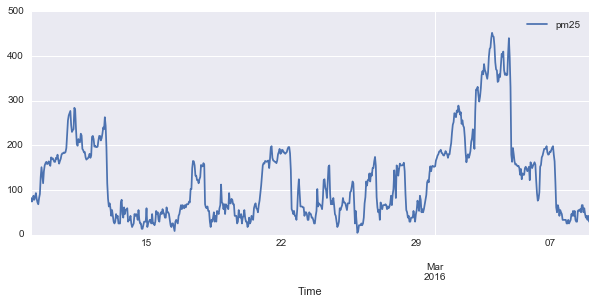

In [126]:
bjair_ts.plot(figsize=(10,4));

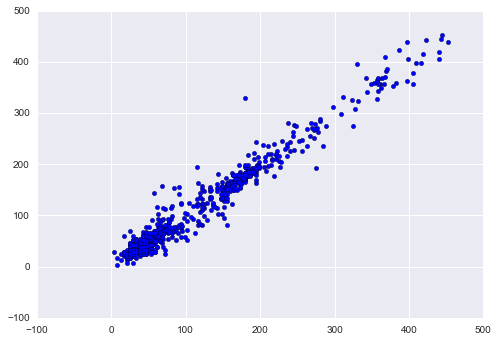

In [127]:
plt.scatter(bjair_ts[1:], bjair_ts[:-1]); # 1hr 正相关

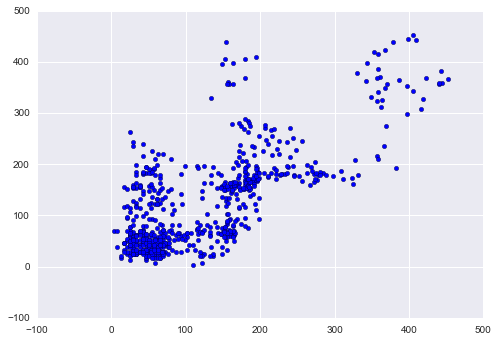

In [130]:
plt.scatter(bjair_ts[12:], bjair_ts[:-12]); #4hr

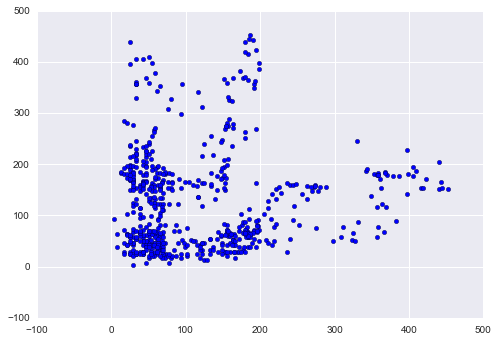

In [131]:
plt.scatter(bjair_ts[72:], bjair_ts[:-72]); 

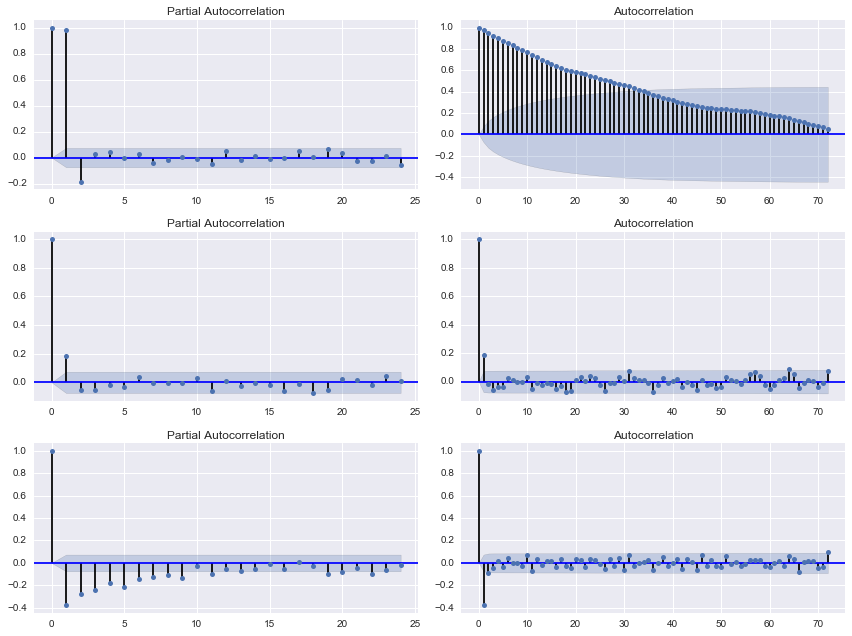

In [132]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9))
#tsa = time series analysis
# partial autocorrelation
smg.tsa.plot_pacf(bjair_ts.pm25, lags=24, ax=axes[0,0])
# autocorrelation
smg.tsa.plot_acf(bjair_ts.pm25, lags=72, ax=axes[0,1])

smg.tsa.plot_pacf(bjair_ts.pm25.diff().dropna(), lags=24, ax=axes[1,0])
smg.tsa.plot_acf(bjair_ts.pm25.diff().dropna(), lags=72, ax=axes[1,1])

smg.tsa.plot_pacf(bjair_ts.pm25.diff().diff().dropna(), lags=24, ax=axes[2,0])
smg.tsa.plot_acf(bjair_ts.pm25.diff().diff().dropna(), lags=72, ax=axes[2,1])

fig.tight_layout()

# AR(2) process
# ARIMA(2,1,0) process?

In [133]:
model = sm.tsa.AR(bjair_ts.pm25)

In [134]:
result = model.fit(maxlag=72,ic='t-stat')
#result = model.fit(5)

In [135]:
sm.stats.durbin_watson(result.resid)
# 接近2, 没有自相关

2.0046371057797461

In [136]:
result.params

const       2.855366
L1.pm25     1.168943
L2.pm25    -0.205052
L3.pm25    -0.016031
L4.pm25     0.055737
L5.pm25    -0.048691
L6.pm25     0.060013
L7.pm25    -0.043227
L8.pm25    -0.014802
L9.pm25     0.023576
L10.pm25    0.060335
L11.pm25   -0.118368
L12.pm25    0.111627
L13.pm25   -0.079037
L14.pm25    0.024896
L15.pm25    0.006004
L16.pm25   -0.058478
L17.pm25    0.053318
L18.pm25   -0.054542
L19.pm25    0.008694
L20.pm25    0.088932
L21.pm25   -0.016021
L22.pm25   -0.040828
L23.pm25    0.056680
L24.pm25   -0.031331
L25.pm25   -0.023988
L26.pm25   -0.043639
L27.pm25    0.072903
L28.pm25   -0.024818
L29.pm25    0.040588
              ...   
L36.pm25   -0.067700
L37.pm25    0.060416
L38.pm25    0.072014
L39.pm25   -0.068463
L40.pm25    0.042432
L41.pm25   -0.033910
L42.pm25   -0.045111
L43.pm25    0.060057
L44.pm25   -0.043421
L45.pm25   -0.025649
L46.pm25    0.115713
L47.pm25   -0.100223
L48.pm25    0.054970
L49.pm25   -0.052501
L50.pm25   -0.005156
L51.pm25    0.099393
L52.pm25   -0

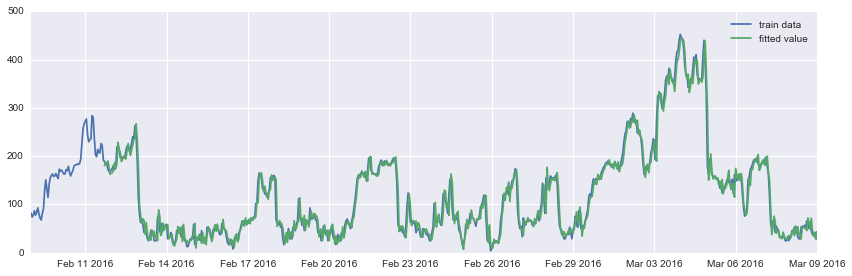

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(bjair_ts, label="train data")
ax.plot(result.fittedvalues, label="fitted value")
ax.legend()
fig.tight_layout()

In [104]:
# 额 这个会不会 overfit?

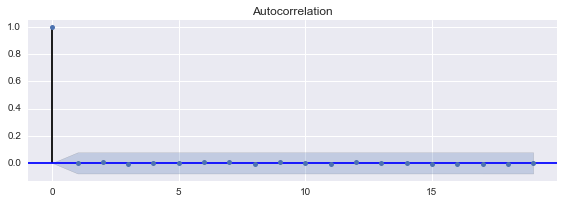

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
smg.tsa.plot_acf(result.resid, lags=19, ax=ax)
fig.tight_layout()

In [161]:
# 读入真实数据与 predicted 对比
bj_test=pd.read_csv("BJ_pm25_test.csv", header=0)
bj_test.head()

,Reading,Time,PM2.5 level,Concentration,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1,2016-03-09 0:00,29,7,NaN,NaN,NaN
1,2,2016-03-09 1:00,25,6,NaN,NaN,NaN
2,3,2016-03-09 2:00,25,6,NaN,NaN,NaN
3,4,2016-03-09 3:00,17,4,NaN,NaN,NaN
4,5,2016-03-09 4:00,25,6,NaN,NaN,NaN


In [162]:
air_test=bj_test[["Time","PM2.5 level"]].set_index('Time')

In [163]:
# change string to datetime
air_test.index = pd.to_datetime(air_test.index)

In [164]:
air_test.columns=["pm25"]

In [165]:
air_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2016-03-09 00:00:00 to 2016-03-12 00:00:00
Data columns (total 1 columns):
pm25    73 non-null int64
dtypes: int64(1)
memory usage: 1.1 KB


In [166]:
air_test.head()

,pm25
Time,
2016-03-09 00:00:00,29
2016-03-09 01:00:00,25
2016-03-09 02:00:00,25
2016-03-09 03:00:00,17
2016-03-09 04:00:00,25


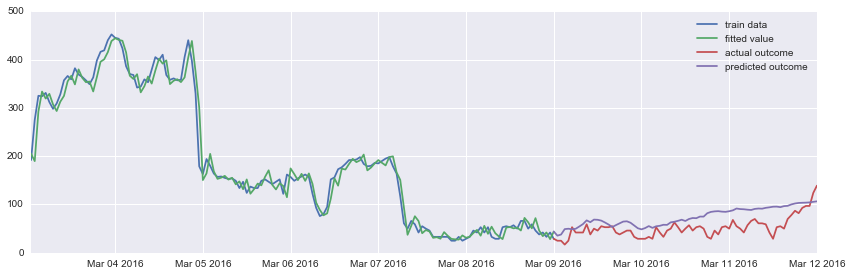

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(bjair_ts.index.values[-144:], bjair_ts.pm25.values[-144:], label="train data")
ax.plot(result.fittedvalues[-144:], label="fitted value")
ax.plot(air_test.index.values,air_test['pm25'].values, label="actual outcome")
ax.plot(pd.date_range("2016-03-09", "2016-03-12", freq="H").values,
        result.predict("2016-03-09", "2016-03-12"), label="predicted outcome")

ax.legend()
fig.tight_layout()

predicted outcome 一般, 趋势大体类似